In [1]:
import torch
import torchvision
from torchvision import datasets , transforms

In [2]:
tarin_data = datasets.MNIST(root="data",train=True,transform=transforms.ToTensor(),download=True,target_transform=None)
test_data = datasets.MNIST(root="data",train=False,transform=transforms.ToTensor(),download=True,target_transform=None)


In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [51]:
classes = test_data.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [52]:
test_data.class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [53]:
image,lable = tarin_data[0]

image , lable

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [54]:
image.shape

torch.Size([1, 28, 28])

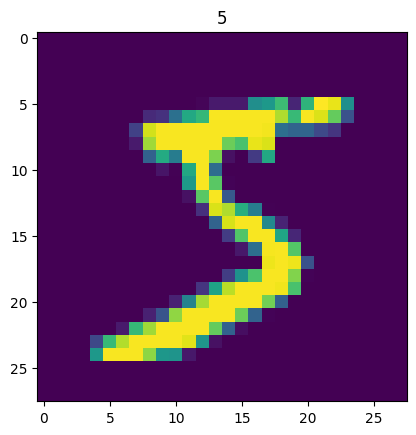

In [55]:
import matplotlib.pyplot as plt

plt.imshow(image.squeeze())
plt.title(lable);

In [56]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=tarin_data,
                              batch_size = BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                              batch_size = BATCH_SIZE,
                              shuffle=False)

In [57]:
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [58]:
import torch.nn as nn
import torch.nn.functional as F

In [96]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

class MNIST(nn.Module):
    def __init__(self):
        super(MNIST,self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self,x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # print(x.shape)
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        
        return x





In [97]:
model=MNIST().to(device)

In [98]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.001)

In [99]:
model

MNIST(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [100]:
def train_step(model:nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device = device):
    
    train_loss , train_acc = 0,0

    for batch,(X,Y) in enumerate(data_loader):

        X,Y = X.to(device),Y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred,Y)

        train_loss += loss

        train_acc += accuracy_fn(Y,y_pred.argmax(dim=1))

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [101]:
def test_step(model:nn.Module,
              data_loader:torch.utils.data.DataLoader,
              loss_fn:nn.Module,
              accuracy_fn,
              device:torch.device = device):
    
    test_loss , test_acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X ,Y in data_loader:
            X,Y = X.to(device),Y.to(device)

            test_pred = model(X)

            loss = loss_fn(test_pred,Y)

            test_loss += loss

            test_acc += accuracy_fn(Y,test_pred.argmax(dim=1))

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%\n")

In [102]:
from helper_functions import accuracy_fn

In [103]:
device

'cuda'

In [105]:
torch.manual_seed(42)



epochs = 5

for epoch in range(epochs):

    print(f"Epoch: {epoch}\n--------")

    train_step(model=model,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    

    test_step(model=model,
              data_loader=test_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    




Epoch: 0
--------
Train loss: 1.46373 | Train acc: 70.91%
Test loss: 0.69866 | Test acc: 82.68%

Epoch: 1
--------
Train loss: 0.54020 | Train acc: 85.32%
Test loss: 0.41391 | Test acc: 88.10%

Epoch: 2
--------
Train loss: 0.39848 | Train acc: 88.40%
Test loss: 0.33716 | Test acc: 90.25%

Epoch: 3
--------
Train loss: 0.33937 | Train acc: 90.13%
Test loss: 0.29404 | Test acc: 91.32%

Epoch: 4
--------
Train loss: 0.29839 | Train acc: 91.26%
Test loss: 0.25719 | Test acc: 92.26%



In [115]:
from tqdm.auto import tqdm


def eval_model_gpu(model:torch.nn.Module,
               data_loader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss,acc = 0,0
    model.eval()

    with torch.inference_mode():
        for X,Y in tqdm(data_loader):
            # Make prediction
            X,Y = X.to(device),Y.to(device)
            y_pred = model(X)

            # Accumulate the loss and acc values per batch
            loss += loss_fn(y_pred,Y)

            acc += accuracy_fn(Y,y_pred.argmax(dim=1))
            
        
        # Scale loss and acc to find the average loss/acc per batch

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"Model_name": model.__class__.__name__,
            "model_loss":loss.item(),
            "model_acc":acc}





model_0_results = eval_model_gpu(model=model,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)

model_0_results

100%|██████████| 313/313 [00:01<00:00, 192.01it/s]


{'Model_name': 'MNIST',
 'model_loss': 0.25719153881073,
 'model_acc': 92.2623801916933}